In [49]:
import time
from datetime import datetime
from datetime import timedelta
import pandas as pd
import pickle
import os
import math
import numpy as np

In [50]:
action_1_path = './data/JData_Action_201602.csv'
action_2_path = './data/JData_Action_201603.csv'
action_3_path = './data/JData_Action_201604.csv'
comment_path = './data/JData_Comment.csv'
product_path = './data/JData_Product.csv'
user_path = './data/JData_User.csv'
tmp_path = 'cache2/'

In [51]:
# 所有用户特征
def get_basic_user_feat():
    dump_path = tmp_path + 'basic_user_feat.pkl'
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            user = pickle.load(f)
    else:
        user = pd.read_csv(user_path, encoding='gbk')
        # 注册日期中有三个缺失值，删除这三个缺失值
        user = user[user['user_reg_tm'].isnull() == False]
        # 注册日期中存在大于'2016-04-15'的现象，经过探索，这部分用户无购买行为，故直接删除
        user = user[user['user_reg_tm'] <= '2016-04-15']
        # 据京东会员等级规则，注册成功即为注册会员，
        # 成长值分别大于0、2000、10000、30000分别为铜牌会员、银牌会员、金牌会员、钻石会员
        # 删除注册会员，会员的成长值分别取平均值1、5、20、40 (成长值平均值除以1000)
        user = user[user['user_lv_cd'] > 1]
        growth_dict = {2: 1, 3: 5, 4: 20, 5: 40}
        user['growth_value'] = user['user_lv_cd'].map(growth_dict)
        # 用户数据中存在着很多用户'2016-04-01'后注册的用户却具有4、5的等级，且在行为数据中大部分并无购买行为，
        # 因此猜测用户等级数据并非采集于'2016-04-15'，而可能采集于比赛开始前一段时间，假设为'2017-01-01'
        user['user_reg_days'] = user['user_reg_tm'].map(lambda x: (datetime.strptime('2017-01-01', '%Y-%m-%d') -
                                                                   datetime.strptime(x, '%Y-%m-%d')).days)
        user['growth_reg_ratio'] = user['growth_value'] / (1 + user['user_reg_days'].apply(np.log1p)) / 5
        age_dict = {u'-1': 0,
                    u'15岁以下': 1,
                    u'16-25岁': 2,
                    u'26-35岁': 3,
                    u'36-45岁': 4,
                    u'46-55岁': 5,
                    u'56岁以上': 6}
        user['age'] = user['age'].map(age_dict).fillna(-1)
        user['sex'] = user['sex'].fillna(2)
        age_dummies = pd.get_dummies(user['age'], prefix='age')
        sex_dummies = pd.get_dummies(user['sex'], prefix='sex')
        user_lv_dummies = pd.get_dummies(user['user_lv_cd'], prefix='user_lv_cd')
        user = pd.concat([user[['user_id', 'growth_reg_ratio']], age_dummies, sex_dummies, user_lv_dummies], axis=1)
        with open(dump_path, 'wb') as f:
            pickle.dump(user, f)
    return(user)

In [52]:
# 所有商品特征
def get_basic_product_feat():
    dump_path = tmp_path + 'basic_product_feat.pkl'
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            product = pickle.load(f)
    else:
        product = pd.read_csv(product_path)
        attr1_dummies = pd.get_dummies(product['a1'], prefix='a1')
        attr2_dummies = pd.get_dummies(product['a2'], prefix='a2')
        attr3_dummies = pd.get_dummies(product['a3'], prefix='a3')
        product = pd.concat([product[['sku_id', 'cate', 'brand']], attr1_dummies, attr2_dummies, attr3_dummies], axis=1)
        with open(dump_path, 'wb') as f:
            pickle.dump(product, f)
    return(product)

In [53]:
comment_dates = ['2016-02-01', '2016-02-08', '2016-02-15', '2016-02-22', '2016-02-29',
                '2016-03-07', '2016-03-14', '2016-03-21', '2016-03-28',
                '2016-04-04', '2016-04-11', '2016-04-15']

In [54]:
def get_comments_product_feat(end_date):
    for date in reversed(comment_dates):
            if date <= end_date:
                comment_date = date
                break
    dump_path = tmp_path + 'comments_%s.pkl' % (comment_date)
    
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            comments = pickle.load(f)
    else:
        comments = pd.read_csv(comment_path)
        comments = comments[comments.dt == comment_date]
        dummies = pd.get_dummies(comments['comment_num'], prefix='comment_num')
        comments = pd.concat([comments, dummies], axis=1)
        comments = comments[['sku_id', 'has_bad_comment', 'bad_comment_rate',
                             'comment_num_1', 'comment_num_2', 'comment_num_3', 'comment_num_4']]
        with open(dump_path, 'wb') as f:
            pickle.dump(comments, f)
    return(comments)

In [55]:
# 获取end_date之前天数为days的行为数据
def get_actions(end_date, days = 60):
    dump_path = tmp_path + 'actions_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = days)
        start_date = start_date.strftime('%Y-%m-%d')
        action_1 = pd.read_csv(action_1_path)
        action_2 = pd.read_csv(action_2_path)
        action_3 = pd.read_csv(action_3_path)
        actions = pd.concat([action_1, action_2, action_3])
        #actions = actions.drop_duplicates()
        actions = actions[(actions.time >= start_date) & (actions.time < end_date)]
        actions['user_id'] = actions['user_id'].astype(int)
        actions = actions[['user_id', 'sku_id', 'time', 'type', 'cate', 'brand']]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    return(actions)

In [56]:
# 获取end_date之前按时间窗口days_window划分的时间区间内的行为特征
# 例date_date = '2016-04-06', days_window = (1, 3, 7, 14, 30),
# 本函数返回 用户-商品对 从2016-04-06往前1天内、1~3天内、3~7天内、7~14天内、14~30天内的浏览和、加购物车和、下单和等
def get_action_feat(end_date, days_window):
    dump_path = tmp_path + 'action_feat_%s_%d_days.pkl' % (end_date, days_window[-1])
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            action_feat = pickle.load(f)
    else:
        actions_raw = get_actions(end_date, days_window[-1])
        actions_raw = actions_raw[['user_id', 'sku_id', 'type', 'time']]
        feats = ['type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6']
        action_feat = None
        end_day = 0
        action_end_date = end_date
        for start_day in days_window:
            action_start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = start_day)
            action_start_date = action_start_date.strftime('%Y-%m-%d %H:%M:%S')
            actions = actions_raw[(actions_raw.time >= action_start_date) & (actions_raw.time < action_end_date)]
            actions = actions[['user_id', 'sku_id', 'type']]
            
            # this user this product
            tutp_feats = ['rct_%d_%d_day_tutp_%s' % (end_day, start_day, x) for x in feats]
            dummies = pd.get_dummies(actions['type'], prefix='rct_%d_%d_day_tutp_type' % (end_day, start_day))
            dummies = dummies.apply(np.log1p) / (30 * start_day)
            dummies.iloc[:, 0] /= 3
            dummies.iloc[:, 1:5] *= 10
            dummies.iloc[:, 5] /= 3
            tutp_df = pd.concat([actions[['user_id', 'sku_id']], dummies], axis=1)
            tutp_df = tutp_df.groupby(['user_id', 'sku_id'], as_index=False).sum()
            
            #end_day = start_day
            #action_end_date = action_start_date
            
            if action_feat is None:
                action_feat = tutp_df
            else:
                action_feat = pd.merge(action_feat, tutp_df, how='outer', on=['user_id', 'sku_id'])

        #with open(dump_path, 'wb') as f:
        #    pickle.dump(action_feat, f)
    return(action_feat)

In [57]:
def select_user(actions, end_date, days = 60):
    print(u'选择用户前user-sku对数: %d' % actions.shape[0])
    action_data = get_actions(end_date, days)
    
    # 过去有过购买记录的用户
    user_1 = action_data[action_data['type'] == 4]['user_id']
    
    # 过去7天有过行为的用户
    start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days = 30)
    start_date = start_date.strftime('%Y-%m-%d')
    user_2 = action_data[(action_data.time >= start_date) & (action_data.time < end_date)]
    user_2 = user_2['user_id']
        
    # 只有过去有过购买记录的用户，或者过去7天有过行为的用户才可能购买商品
    user_3 = set(user_1) | set(user_2)
    user_index = actions['user_id'].isin(user_3)
    actions = actions[user_index]
    print(u'选择用户后user-sku对数: %d' % actions.shape[0])
    
    return(actions)

In [58]:
def select_prod(actions, end_date, days = 60):
    print(u'选择商品前user-sku对数: %d' % actions.shape[0])
    action_data = get_actions(end_date, days)
    
    # 如果某些商品用户都最多只购买了一次，并且某位用户已经购买了，那认为它不会再购买了
    dummies = pd.get_dummies(action_data['type'], prefix = 'type')
    action_data = pd.concat([action_data[['user_id', 'sku_id']], dummies], axis=1)
    action_data = action_data.groupby(['user_id', 'sku_id'], as_index = False).sum()
    # 已购买过该商品的用户-商品对
    df = action_data[action_data['type_4'] == 1]
    
    # 挑出最多只被购买多一次的商品
    df2 = action_data[['sku_id', 'type_4']].groupby(['sku_id'], as_index = False).max()
    sku_index = df2[df2['type_4'] == 1]['sku_id'].values
    sku_index = df['sku_id'].isin(sku_index)
    df = df[sku_index]
    rm_user_sku = df['user_id'].astype(str) + '_' + df['sku_id'].astype(str)
    actions_user_sku = actions['user_id'].astype(str) + '_' + actions['sku_id'].astype(str)
    rm_user_sku = rm_user_sku.values
    user_sku_index = 1 - actions_user_sku.isin(rm_user_sku)
    actions = actions[user_sku_index.astype(bool)]
    print(u'选择商品后user-sku对数: %d' % actions.shape[0])
    return(actions)

In [59]:
# 购买后是否还有浏览行为
def whether_action_after_buy(end_date, days = 30):
    print(u'计算购买后是否还有浏览行为...')
    dump_path = tmp_path + 'ang_type_after_buy_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            df = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        actions = actions[['user_id', 'sku_id', 'time', 'type']]
        actions = actions.sort_values(by = ['user_id', 'sku_id', 'time'])
        actions = actions.reset_index(drop = True)
        actions = actions.reset_index()
        
        actions_4 = actions[actions.type == 4]
        df = actions[['user_id', 'sku_id', 'index']].groupby(['user_id', 'sku_id'], as_index=False).max()
        df_4 = actions_4[['user_id', 'sku_id', 'index']].groupby(['user_id', 'sku_id'], as_index=False).max()
        
        df = pd.merge(df, df_4, how='left', on=['user_id', 'sku_id'])
        df = df.fillna(0)
        #df['whether_has_buy'] = df['index_y'].astype(bool).astype(int)
        df['whether_action_after_buy'] = (df['index_x'] > df['index_y']) | (df['index_y'] == 0)
        df['whether_action_after_buy'] = df['whether_action_after_buy'].astype(int)
        
        df = df[['user_id', 'sku_id', 'whether_action_after_buy']]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(df, f)
    
    return(df)

In [60]:
def prod_rank_of_user(end_date, days = 30):
    print(u'计算对同一用户，不同商品type值的排名')
    dump_path = tmp_path + 'prod_rank_of_user_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix = 'type')
        actions = pd.concat([actions[['user_id', 'sku_id']], dummies], axis=1)
        actions = actions.groupby(['user_id', 'sku_id'], as_index = False).sum()
        
        feats = ['type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6']
        feats2 = ['prod_rank_of_user_' + i for i in feats]
        for i in range(len(feats)):
            df = actions[['user_id', 'sku_id', feats[i]]]
            df = df.sort_values(by = ['user_id', feats[i]], ascending=False)
            df = df.reset_index(drop=True)
            df = df.reset_index()
            df2 = df[['user_id', 'index']].groupby(['user_id'], as_index=False).min()
            df = pd.merge(df, df2, how='left', on='user_id')
            df[feats2[i]] = 1 / (df['index_x'] - df['index_y'] + 1)
            df3 = df[['user_id', feats[i], feats2[i]]].groupby(['user_id', feats[i]], as_index=False).max()
            df = df[['user_id', 'sku_id', feats[i]]]
            df = pd.merge(df, df3, how='left', on=['user_id', feats[i]])
            actions = pd.merge(actions, df[['user_id', 'sku_id', feats2[i]]], how='left', on=['user_id', 'sku_id'])
        actions = actions[['user_id', 'sku_id'] + feats2]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    
    return(actions)

In [61]:
def prod_rank_of_cate(end_date, days = 30):
    print(u'计算对同类别，不同商品type值的排名')
    dump_path = tmp_path + 'prod_rank_of_cate_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix = 'type')
        actions = pd.concat([actions[['cate', 'sku_id']], dummies], axis=1)
        actions = actions.groupby(['cate', 'sku_id'], as_index = False).sum()
        
        feats = ['type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6']
        feats2 = ['prod_rank_of_cate_' + i for i in feats]
        for i in range(len(feats)):
            df = actions[['cate', 'sku_id', feats[i]]]
            df = df.sort_values(by = ['cate', feats[i]], ascending=False)
            df = df.reset_index(drop=True)
            df = df.reset_index()
            df2 = df[['cate', 'index']].groupby(['cate'], as_index=False).min()
            df = pd.merge(df, df2, how='left', on='cate')
            df[feats2[i]] = 1 / (df['index_x'] - df['index_y'] + 1)
            df3 = df[['cate', feats[i], feats2[i]]].groupby(['cate', feats[i]], as_index=False).max()
            df = df[['cate', 'sku_id', feats[i]]]
            df = pd.merge(df, df3, how='left', on=['cate', feats[i]])
            actions = pd.merge(actions, df[['sku_id', feats2[i]]], how='left', on='sku_id')
        actions = actions[['sku_id'] + feats2]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    
    return(actions)

In [62]:
def prod_rank_of_brand(end_date, days = 30):
    print(u'计算对同品牌，不同商品type值的排名')
    dump_path = tmp_path + 'prod_rank_of_brand_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix = 'type')
        actions = pd.concat([actions[['brand', 'sku_id']], dummies], axis=1)
        actions = actions.groupby(['brand', 'sku_id'], as_index = False).sum()
        
        feats = ['type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6']
        feats2 = ['prod_rank_of_brand_' + i for i in feats]
        for i in range(len(feats)):
            df = actions[['brand', 'sku_id', feats[i]]]
            df = df.sort_values(by = ['brand', feats[i]], ascending=False)
            df = df.reset_index(drop=True)
            df = df.reset_index()
            df2 = df[['brand', 'index']].groupby(['brand'], as_index=False).min()
            df = pd.merge(df, df2, how='left', on='brand')
            df[feats2[i]] = 1 / (df['index_x'] - df['index_y'] + 1)
            df3 = df[['brand', feats[i], feats2[i]]].groupby(['brand', feats[i]], as_index=False).max()
            df = df[['brand', 'sku_id', feats[i]]]
            df = pd.merge(df, df3, how='left', on=['brand', feats[i]])
            actions = pd.merge(actions, df[['sku_id', feats2[i]]], how='left', on='sku_id')
        actions = actions[['sku_id'] + feats2]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    
    return(actions)

In [63]:
def prod_time_rank_of_cate(end_date, days = 30):
    print(u'计算对同一种类，不同商品的浏览顺序排名')
    dump_path = tmp_path + 'prod_time_rank_of_cate_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            df = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        actions = actions.reset_index()
        actions = actions.rename(columns = {'index': 'time_order'})
        actions = actions[(actions.type == 1) | (actions.type == 6)]
        # 第一次浏览时间
        actions = actions.groupby(['user_id', 'sku_id'], as_index=False).first()
        # 最后一次浏览时间
        actions2 = actions.groupby(['user_id', 'sku_id'], as_index=False).last()
        
        #actions['interval_days'] = pd.to_datetime(actions2['time'], format='%Y-%m-%d %H:%M:%S') - pd.to_datetime(actions['time'], format='%Y-%m-%d %H:%M:%S')
        
        df = actions.sort_values(by = ['user_id', 'cate', 'time_order'], ascending=False)
        df = df.reset_index(drop=True)
        df = df.reset_index()
        df2 = df[['user_id', 'cate', 'index']].groupby(['user_id', 'cate'], as_index=False).min()
        df = pd.merge(df, df2, how='left', on=['user_id', 'cate'])
        df['prod_time_rank_of_cate'] = 1 / (df['index_x'] - df['index_y'] + 1)
        df = df[['user_id', 'sku_id', 'prod_time_rank_of_cate']]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(df, f)
    
    return(df)

In [64]:
# 获取用户热度和商品热度
# 即对于每个（用户-商品对），返回该用户对除所研究商品外其它商品的浏览和、加购物车和、下单和等，
# 及该商品除所研究用户外其他用户的浏览和、加购物车和、下单和等
# 不是直接使用该用户对所有商品的行为特征和所有用户对该商品的行为特征和是为了避免特征冗余
def get_others_action_feat(end_date, days = 30):
    dump_path = tmp_path + 'others_action_feat_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            others_action = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        actions = actions[['user_id', 'sku_id', 'type']]
        
        feats = ['type_1', 'type_2', 'type_3','type_4', 'type_5', 'type_6']
        
        # this user this product
        tutp_feats = ['tutp_%s' % x for x in feats]
        dummies = pd.get_dummies(actions['type'], prefix='tutp_type')
        tutp_df = pd.concat([actions[['user_id', 'sku_id']], dummies], axis=1)
        tutp_df = tutp_df.groupby(['user_id', 'sku_id'], as_index=False).sum()

        # this user all product
        tuap_feats = ['tuap_%s' % x for x in feats]
        dummies = pd.get_dummies(actions['type'], prefix='tuap_type')
        tuap_df = pd.concat([actions[['user_id']], dummies], axis=1)
        tuap_df = tuap_df.groupby(['user_id'], as_index=False).sum()
            
        # all user this product
        autp_feats = ['autp_%s' % x for x in feats]
        dummies = pd.get_dummies(actions['type'], prefix='autp_type')
        autp_df = pd.concat([actions[['sku_id']], dummies], axis=1)
        autp_df = autp_df.groupby(['sku_id'], as_index=False).sum()
            
        df = pd.merge(tutp_df, tuap_df, how = 'left', on = ['user_id'])
        df = pd.merge(df, autp_df, how = 'left', on = ['sku_id'])
            
        # this user other product
        tuop_feats = ['tuop_%s' % x for x in feats]
        # other user this product
        outp_feats = ['outp_%s' % x for x in feats]
        for i in range(len(feats)):
            df[tuop_feats[i]] = df[tuap_feats[i]] - df[tutp_feats[i]]
            df[outp_feats[i]] = df[autp_feats[i]] - df[tutp_feats[i]]
        users = df[['user_id', 'sku_id']]
        tuop_df = df[tuop_feats]
        outp_df = df[outp_feats]
        tuop_df = tuop_df.apply(np.log1p) / 5
        outp_df = outp_df.apply(np.log1p) / 10
        others_action = pd.concat([users, tuop_df, outp_df], axis = 1)

        with open(dump_path, 'wb') as f:
            pickle.dump(others_action, f)
    return(others_action)

In [65]:
# 用户每个行为转化为下单行为的比率
def get_action_and_user_feat(end_date, days = 30):
    dump_path = tmp_path + 'action_and_user_feat_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix='type')
        actions = pd.concat([actions[['user_id']], dummies], axis=1)
        actions = actions.groupby(['user_id'], as_index=False).sum()
        
        user = pd.read_csv(user_path, encoding='gbk')
        user = user[['user_id', 'user_reg_tm']]
        # 注册日期中有三个缺失值，删除这三个缺失值
        user = user[user['user_reg_tm'].isnull() == False]
        user = user[user['user_reg_tm'] <= end_date]
        user['user_reg_days'] = user['user_reg_tm'].map(lambda x: (datetime.strptime(end_date, '%Y-%m-%d') - 
                                                                   datetime.strptime(x, '%Y-%m-%d')).days)
        
        actions = pd.merge(actions, user[['user_id', 'user_reg_days']], how='inner', on='user_id')
        actions['reg_days_type_1_ratio'] = actions['type_1'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 1000
        actions['reg_days_type_2_ratio'] = actions['type_2'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 10
        actions['reg_days_type_3_ratio'] = actions['type_3'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 10
        actions['reg_days_type_4_ratio'] = actions['type_4'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 10
        actions['reg_days_type_5_ratio'] = actions['type_5'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 10
        actions['reg_days_type_6_ratio'] = actions['type_6'] / (1 + actions['user_reg_days'].apply(np.log1p)) / 1000
        actions['user_reg_days'] = 10 / (4 + actions['user_reg_days'])
        
        feature = ['user_id', 'reg_days_type_1_ratio', 'reg_days_type_2_ratio', 'reg_days_type_3_ratio',
                   'reg_days_type_4_ratio', 'reg_days_type_5_ratio', 'reg_days_type_6_ratio', 'user_reg_days']
        actions = actions[feature]
        
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    return(actions)

In [66]:
# 用户每个行为转化为下单行为的比率
def get_user_conversion(end_date, days = 30):
    feature = ['user_type_1_ratio', 'user_type_2_ratio', 'user_type_3_ratio',
               'user_type_5_ratio', 'user_type_6_ratio']
    dump_path = tmp_path + 'user_conversion_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix='type')
        actions = pd.concat([actions[['user_id']], dummies], axis=1)
        actions = actions.groupby(['user_id'], as_index=False).sum()
        actions['user_type_1_ratio'] = actions['type_4'] / (1 + actions['type_1'].apply(np.log1p))
        actions['user_type_2_ratio'] = actions['type_4'] / (1 + actions['type_2'].apply(np.log1p))
        actions['user_type_3_ratio'] = actions['type_4'] / (1 + actions['type_3'].apply(np.log1p))
        actions['user_type_5_ratio'] = actions['type_4'] / (1 + actions['type_5'].apply(np.log1p))
        actions['user_type_6_ratio'] = actions['type_4'] / (1 + actions['type_6'].apply(np.log1p))
        users = actions['user_id']
        actions = actions[feature].applymap(lambda x: 1 if x > 1 else x)
        actions = pd.concat([users, actions], axis = 1)
        actions = actions.fillna(0).replace(np.inf, 0)
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    return(actions)

In [67]:
# 对每个商品的行为转化为下单行为的比率
def get_product_conversion(end_date, days = 30):
    feature = ['product_type_1_ratio', 'product_type_2_ratio', 'product_type_3_ratio',
               'product_type_5_ratio', 'product_type_6_ratio']
    dump_path = tmp_path + 'product_conversion_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        dummies = pd.get_dummies(actions['type'], prefix='type')
        actions = pd.concat([actions[['sku_id']], dummies], axis=1)
        actions = actions.groupby(['sku_id'], as_index=False).sum()
        actions['product_type_1_ratio'] = actions['type_4'] / (1 + actions['type_1'].apply(np.log1p))
        actions['product_type_2_ratio'] = actions['type_4'] / (1 + actions['type_2'].apply(np.log1p))
        actions['product_type_3_ratio'] = actions['type_4'] / (1 + actions['type_3'].apply(np.log1p))
        actions['product_type_5_ratio'] = actions['type_4'] / (1 + actions['type_5'].apply(np.log1p))
        actions['product_type_6_ratio'] = actions['type_4'] / (1 + actions['type_6'].apply(np.log1p))
        prods = actions['sku_id']
        actions = actions[feature].applymap(lambda x: 1 if x > 1 else x)
        actions = pd.concat([prods, actions], axis = 1)
        actions = actions.fillna(0).replace(np.inf, 0)
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)
    return(actions)

In [68]:
# 返回end_date前days天内(用户-商品对)的label(即是否下单）
def get_labels(end_date, days=5):
    dump_path = tmp_path + 'labels_%s_%d.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        actions = get_actions(end_date, days)
        actions = actions[actions['type'] == 4]
        actions = actions.groupby(['user_id', 'sku_id'], as_index=False).sum()
        actions['label'] = 1
        actions = actions[['user_id', 'sku_id', 'label']]
        with open(dump_path, 'wb') as f:
            pickle.dump(actions, f)

    return(actions)

In [69]:
# 将所有特征合并
def make_train_set(end_date, days = 30):
    dump_path = tmp_path + 'train_set_%s_%d_days.pkl' % (end_date, days)
    print(u'计算%s往前%d天内的特征值...' % (end_date, days))
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            actions = pickle.load(f)
    else:
        user = get_basic_user_feat()
        product = get_basic_product_feat()
        comment = get_comments_product_feat(end_date)
        others_action = get_others_action_feat(end_date, days)
        user_conv = get_user_conversion(end_date, days)
        product_conv = get_product_conversion(end_date, days)
        action_by_reg = get_action_and_user_feat(end_date, days)
        action_after_buy = whether_action_after_buy(end_date, days)
        
        # 时间窗口
        days_window = [1, 3, 7, 14, 30]
        actions = get_action_feat(end_date, days_window)
        #actions = select_user(actions, end_date, days)
        #actions = select_prod(actions, end_date, days)
        actions = pd.merge(actions, others_action, how='left', on=['user_id', 'sku_id'])
        actions = pd.merge(actions, user, how='inner', on='user_id')
        actions = pd.merge(actions, user_conv, how='left', on='user_id')
        actions = pd.merge(actions, product, how='left', on='sku_id')
        actions = pd.merge(actions, product_conv, how='left', on='sku_id')
        actions = pd.merge(actions, action_by_reg, how='left', on='user_id')
        actions = pd.merge(actions, comment, how='left', on='sku_id')
        actions = pd.merge(actions, action_after_buy, how='left', on=['user_id', 'sku_id'])
        
        weights = [1, 20, 1, 1, 20, 1]
        prod_rank_user = prod_rank_of_user(end_date, days)
        #prod_rank_brand = prod_rank_of_brand(end_date, days)
        #prod_rank_cate = prod_rank_of_cate(end_date, days)
        prod_time_rank_cate = prod_time_rank_of_cate(end_date, days)
        actions = pd.merge(actions, prod_rank_user, how='left', on=['user_id', 'sku_id'])
        #actions = pd.merge(actions, prod_rank_brand, how='left', on='sku_id')
        #actions = pd.merge(actions, prod_rank_cate, how='left', on='sku_id')
        actions = pd.merge(actions, prod_time_rank_cate, how='left', on=['user_id', 'sku_id'])
        
        actions = actions.fillna(0)
        #with open(dump_path, 'wb') as f:
        #    pickle.dump(actions, f)
    
    users = actions[['user_id', 'sku_id']].copy()
    del actions['user_id']
    del actions['sku_id']
    del actions['brand']
    return(users, actions)

In [70]:
# 将make_train_set得到的(用户-商品对)标注其在测试日期内是否下过单
def get_test_labels(users, end_date, days = 5):
    dump_path = tmp_path + 'test_labels_%s_%d_days.pkl' % (end_date, days)
    if os.path.exists(dump_path):
        with open(dump_path, 'rb') as f:
            labels = pickle.load(f)
    else:
        labels = get_labels(end_date, days)
        labels = pd.merge(users, labels, how='left', on=['user_id', 'sku_id'])
        labels = labels.fillna(0)
        labels = labels['label'].astype(int)
        #with open(dump_path, 'wb') as f:
        #    pickle.dump(labels, f)
    return(labels)

In [71]:
def report(pred, label):
    actions = label
    result = pred
    
    # 所有购买用户
    all_user_set = actions['user_id'].unique()
    # 所有用户商品对
    all_user_item_pair = actions['user_id'].map(str) + '-' + actions['sku_id'].map(str)
    all_user_item_pair = np.array(all_user_item_pair)
    
    # 所有品类中预测购买的用户
    all_user_test_set = result['user_id'].unique()
    all_user_test_item_pair = result['user_id'].map(str) + '-' + result['sku_id'].map(str)
    all_user_test_item_pair = np.array(all_user_test_item_pair)
    
    # 计算所有用户购买评价指标
    pos, neg = 0,0
    for user_id in all_user_test_set:
        if user_id in all_user_set:
            pos += 1
        else:
            neg += 1
    all_user_acc = 1.0 * pos / ( pos + neg)
    all_user_recall = 1.0 * pos / len(all_user_set)
    print(u'所有用户中预测购买用户的准确率为 ' + str(all_user_acc))
    print(u'所有用户中预测购买用户的召回率为 ' + str(all_user_recall))
    
    pos, neg = 0, 0
    for user_item_pair in all_user_test_item_pair:
        if user_item_pair in all_user_item_pair:
            pos += 1
        else:
            neg += 1
    all_item_acc = 1.0 * pos / ( pos + neg)
    all_item_recall = 1.0 * pos / len(all_user_item_pair)
    print(u'所有用户中预测购买商品的准确率为 ' + str(all_item_acc))
    print(u'所有用户中预测购买商品的召回率为 ' + str(all_item_recall))
    F11 = 6.0 * all_user_recall * all_user_acc / (5.0 * all_user_recall + all_user_acc)
    F12 = 5.0 * all_item_acc * all_item_recall / (2.0 * all_item_recall + 3 * all_item_acc)
    score = 0.4 * F11 + 0.6 * F12
    print('F11 = ' + str(F11))
    print('F12 = ' + str(F12))
    print('score = ' + str(score))
    return(score)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import xgboost as xgb

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [74]:
def model_predict(learner, train_data, label, sub_train_data):
    print(u'训练集和验证集中正样本数：%d, 负样本数：%d' % (label[label == 1].shape[0], label[label == 0].shape[0]))
    col_index = train_data.columns
    sub_train_data = sub_train_data[col_index]
    SEED = 17
    X_train, X_cv, y_train, y_cv = train_test_split(train_data.values,
                                                    label.values,
                                                    test_size=0.3,
                                                    random_state=SEED)
    if learner == 'XGB':
        print(u'使用xgboost模型进行预测')
        dtrain = xgb.DMatrix(X_train, label = y_train)
        dtest = xgb.DMatrix(X_cv, label = y_cv)
        param = {'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 3,  # 此处用函数使用过max_depth的取值，为3时得分最高
             'min_child_weight': 5, 'gamma': 1, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'scale_pos_weight': 1, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
        num_round = 150
        param['nthread'] = 40
        param['eval_metric'] = 'auc'
        plst = list(param.items())
        plst += [('eval_metric', 'logloss')]
        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(plst, dtrain, num_round, evallist)
        
        sub_dtrain = xgb.DMatrix(sub_train_data.values)
        y = bst.predict(sub_dtrain)
        return(y)
    else:
        train_data = train_data.as_matrix()
        label = label.as_matrix()
        sub_train_data = sub_train_data.as_matrix()
        if learner == 'RF':
            model = RandomForestClassifier(oob_score=True, n_estimators=10000)
        elif learner == 'XT':
            model = ExtraTreesClassifier(n_estimators=1999,
                                         max_features='sqrt',
                                         max_depth=None,
                                         min_samples_split=8,
                                         random_state=SEED)
        elif learner == 'GBDT':
            model = GradientBoostingClassifier(n_estimators=200,
                                               learning_rate=0.20,
                                               max_depth=20,
                                               min_samples_split=9,
                                               random_state=SEED)
        elif learner == 'LR':
            model = LogisticRegression(C=1.0, penalty='l2', tol=1e-6, solver='sag')
        elif learner == 'NB':
            model = MultinomialNB(alpha = 0.01)
        elif learner == 'KNN':
            model = KNeighborsClassifier()
        elif learner == 'DT':
            model = DecisionTreeClassifier()
        elif learner == 'SVM':
            model = SVC(kernel='rbf', probability=True)
        model.fit(train_data, label)
        pred = model.predict_proba(sub_train_data)
        pred = pred[:,1].reshape((1, -1))
        return(pred[0])

In [75]:
def select_max_proba(result):
    result = result.sort_values(['user_id', 'label'])
    result = result.reset_index(drop=True)
    result = result.reset_index()
    index_max = result[['user_id', 'index']].groupby('user_id', as_index=False).max()
    result = result.loc[index_max['index'], :]
    return(result[['user_id', 'sku_id', 'label']])

In [76]:
def repeat_train(learner, train_end_date, sub_train_end_date, repeat_times, interval_days, only_pred_cate8=False):
    test_end_date = datetime.strptime(train_end_date, '%Y-%m-%d') + timedelta(days = 5)
    test_end_date = test_end_date.strftime('%Y-%m-%d')
    sub_user_index, sub_train_data = make_train_set(sub_train_end_date)
    if only_pred_cate8 == True:
        sub_train_data = sub_train_data[sub_train_data.cate == 8]
    results = np.zeros((sub_train_data.shape[0], repeat_times))
    skip_times = 0
    for i in range(repeat_times):
        print(u'开始日期为%s的训练，第%d/%d次' % (train_end_date, i + 1, repeat_times))
        if train_end_date in ['2016-03-14', '2016-03-13', '2016-03-08', '2016-03-07']:
            skip_times += 1
            print(u'跳过本轮循环')
            train_end_date = datetime.strptime(train_end_date, '%Y-%m-%d') - timedelta(days = interval_days)
            train_end_date = train_end_date.strftime('%Y-%m-%d')
            test_end_date = datetime.strptime(test_end_date, '%Y-%m-%d') - timedelta(days = interval_days)
            test_end_date = test_end_date.strftime('%Y-%m-%d')
            continue
        else:
            user_index, train_data = make_train_set(train_end_date)
            label = get_test_labels(user_index, test_end_date)
            preds = model_predict(learner, train_data, label, sub_train_data)
            results[:,i] = preds
        train_end_date = datetime.strptime(train_end_date, '%Y-%m-%d') - timedelta(days = interval_days)
        train_end_date = train_end_date.strftime('%Y-%m-%d')
        test_end_date = datetime.strptime(test_end_date, '%Y-%m-%d') - timedelta(days = interval_days)
        test_end_date = test_end_date.strftime('%Y-%m-%d')
    #results = results / (repeat_times - skip_times)
    print('skip_times: %d' % skip_times)
    return(results)

In [83]:
# 只使用XGBoost模型，每隔5天提取特征，共提取6次进行训练

train_end_date = '2016-04-03'
test_end_date = '2016-04-08'
sub_train_end_date = '2016-04-08'
sub_test_end_date = '2016-04-13'

sub_user_index, sub_train_data = make_train_set(sub_train_end_date)
sub_label = get_labels(sub_test_end_date)

preds = repeat_train('XGB', train_end_date, sub_train_end_date, 6, 5)

result_df = sub_user_index.copy()
result_df['label'] = np.sum(preds, axis=1) / 6
result = select_max_proba(result_df)

s = list([])
for threshold in np.arange(0.025, 0.045, 0.001):
    pred = result[result['label'] >= threshold]
    pred = pred[['user_id', 'sku_id']]
    print('')
    print('threshold: %f' % threshold)
    print(u'预测购买数：%d， 实际购买数：%d' % (pred.shape[0], sub_label.shape[0]))
    score = report(pred, sub_label)
    s.append([threshold, score])
print(s)

计算2016-04-08往前30天内的特征值...
计算购买后是否还有浏览行为...
计算对同一用户，不同商品type值的排名
计算对同一种类，不同商品的浏览顺序排名
计算2016-04-08往前30天内的特征值...
计算购买后是否还有浏览行为...
计算对同一用户，不同商品type值的排名
计算对同一种类，不同商品的浏览顺序排名
开始日期为2016-04-03的训练，第1/6次
计算2016-04-03往前30天内的特征值...
计算购买后是否还有浏览行为...
计算对同一用户，不同商品type值的排名
计算对同一种类，不同商品的浏览顺序排名
训练集和验证集中正样本数：1351, 负样本数：2019551
使用xgboost模型进行预测
[0]	eval-auc:0.632401	eval-logloss:0.59839	train-auc:0.639178	train-logloss:0.598389
[1]	eval-auc:0.677906	eval-logloss:0.520786	train-auc:0.68722	train-logloss:0.520785
[2]	eval-auc:0.725264	eval-logloss:0.456081	train-auc:0.726725	train-logloss:0.45608
[3]	eval-auc:0.732135	eval-logloss:0.401393	train-auc:0.732237	train-logloss:0.401391
[4]	eval-auc:0.732126	eval-logloss:0.354679	train-auc:0.732257	train-logloss:0.354677
[5]	eval-auc:0.7333	eval-logloss:0.314449	train-auc:0.732583	train-logloss:0.314445
[6]	eval-auc:0.75199	eval-logloss:0.279561	train-auc:0.750065	train-logloss:0.279557
[7]	eval-auc:0.751967	eval-logloss:0.249141	train-auc:0.750087	train-logloss:0.

In [49]:
# 模型融合
train_end_date = '2016-04-01'
test_end_date = '2016-04-06'
val_train_end_date = '2016-04-06'
val_test_end_date = '2016-04-11'
sub_train_end_date = '2016-04-11'
sub_test_end_date = '2016-04-16'

val_user_index, val_train_data = make_train_set(val_train_end_date)
val_label = get_test_labels(val_user_index, val_test_end_date)
sub_user_index, sub_train_data = make_train_set(sub_train_end_date)
sub_label = get_labels(sub_test_end_date)

models = ['LR', 'NB', 'DT']
results1 = {}
for model in models:
    preds = repeat_train(model, train_end_date, val_train_end_date, 1, 10)
    preds[preds > 0.9999999] = 0.9999999
    preds[preds < 0.0000001] = 0.0000001
    preds = -np.log((1 - preds) / preds)
    results1[model] = preds
results1 = pd.DataFrame(results1)

results2 = {}
for model in models:
    preds = repeat_train(model, val_train_end_date, sub_train_end_date, 1, 10)
    preds[preds > 0.9999999] = 0.9999999
    preds[preds < 0.0000001] = 0.0000001
    preds = -np.log((1 - preds) / preds)
    results2[model] = preds
results2 = pd.DataFrame(results2)

lr = LogisticRegression()
lr.fit(results1.values, val_label.values)
print(lr.coef_)
preds = lr.predict_proba(results2.values)

result_df = sub_user_index.copy()
result_df['label'] = preds[:, 1]
result = select_max_proba(result_df)

s = list([])
for threshold in np.arange(0, 0.15, 0.01):
    pred = result[result['label'] >= threshold]
    pred = pred[['user_id', 'sku_id']]
    print('')
    print('threshold: %f' % threshold)
    print(u'预测购买数：%d， 实际购买数：%d' % (pred.shape[0], sub_label.shape[0]))
    score = report(pred, sub_label)
    s.append([threshold, score])
print(s)

计算2016-04-06往前30天内的特征值...
计算2016-04-11往前30天内的特征值...
计算2016-04-06往前30天内的特征值...
开始日期为2016-04-01的训练，第1/1次
计算2016-04-01往前30天内的特征值...
使用LR模型训练第1次
训练集和验证集中正样本数：2468, 负样本数：202654


/home/maqiao/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


使用LR模型训练第2次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第3次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第4次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第5次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第6次
训练集和验证集中正样本数：2468, 负样本数：202654
使用LR模型训练第7次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第8次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第9次
训练集和验证集中正样本数：2468, 负样本数：202655
使用LR模型训练第10次
训练集和验证集中正样本数：2468, 负样本数：202655
计算2016-04-06往前30天内的特征值...
开始日期为2016-04-01的训练，第1/1次
计算2016-04-01往前30天内的特征值...
训练集和验证集中正样本数：1234, 负样本数：2026548
计算2016-04-06往前30天内的特征值...
开始日期为2016-04-01的训练，第1/1次
计算2016-04-01往前30天内的特征值...
训练集和验证集中正样本数：1234, 负样本数：2026548
计算2016-04-11往前30天内的特征值...
开始日期为2016-04-06的训练，第1/1次
计算2016-04-06往前30天内的特征值...
使用LR模型训练第1次
训练集和验证集中正样本数：4082, 负样本数：200454
使用LR模型训练第2次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第3次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第4次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第5次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第6次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第7次
训练集和验证集中正样本数：4082, 负样本数：200455
使用LR模型训练第8次
训练集和

In [44]:
# 使用Naive Bayes, Decision Tree, XGBoost融合预测提交
train_end_date = '2016-04-06'
test_end_date = '2016-04-11'
val_train_end_date = '2016-04-11'
val_test_end_date = '2016-04-16'
sub_train_end_date = '2016-04-16'
sub_test_end_date = '2016-04-20'
    
user_index, train_data = make_train_set(train_end_date)
label = get_test_labels(user_index, test_end_date)
val_user_index, val_train_data = make_train_set(val_train_end_date)
val_label = get_test_labels(val_user_index, val_test_end_date)
sub_user_index, sub_train_data = make_train_set(sub_train_end_date)
sub_user_index = sub_user_index[sub_train_data.cate == 8]
sub_train_data = sub_train_data[sub_train_data.cate == 8]
#sub_label = get_labels(sub_test_end_date)
    
models = ['NB', 'DT', 'XGB']
results1 = {}
for model in models:
    preds = ensemble(model, train_data, label, val_train_data, 2, 3)
    preds[preds > 0.9999999] = 0.9999999
    preds[preds < 0.0000001] = 0.0000001
    preds = -np.log((1 - preds) / preds)
    results1[model] = preds
results1 = pd.DataFrame(results1)

results2 = {}
for model in models:
    preds = ensemble(model, train_data, label, sub_train_data, 2, 3)
    preds[preds > 0.9999999] = 0.9999999
    preds[preds < 0.0000001] = 0.0000001
    preds = -np.log((1 - preds) / preds)
    results2[model] = preds
results2 = pd.DataFrame(results2)

lr = LogisticRegression()
lr.fit(results1.values, val_label.values)
print(lr.coef_)
preds = lr.predict_proba(results2.values)

result_df = sub_user_index.copy()
result_df['label'] = preds[:, 1]
result = select_max_proba(result_df)

for threshold in np.arange(0.01, 0.02, 0.001):
    pred = result[result['label'] >= threshold]
    pred = pred[['user_id', 'sku_id']]
    
    print(u'预测购买数：%d' % pred.shape[0])
    pred.to_csv('./sub/sub_%s_%.3f_%d.csv'%(datetime.now().strftime('%Y-%m-%d'),
                                            threshold, pred.shape[0]), index=False, index_label=False)

计算2016-04-06往前60天内的特征值...
计算2016-04-11往前60天内的特征值...
计算2016-04-16往前60天内的特征值...
计算购买后是否还有浏览行为...
计算对同一用户，不同商品type值的排名
计算对同品牌，不同商品type值的排名
计算对同类别，不同商品type值的排名
计算对同一种类，不同商品的浏览顺序排名
使用NB模型训练第1次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用NB模型训练第2次
训练集和验证集中正样本数：8592, 负样本数：1044295


/home/maqiao/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


使用NB模型训练第3次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用DT模型训练第1次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用DT模型训练第2次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用DT模型训练第3次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用XGB模型训练第1次
训练集和验证集中正样本数：8592, 负样本数：1044295
使用xgboost模型进行预测
[0]	eval-auc:0.756249	eval-logloss:0.60096	train-auc:0.758511	train-logloss:0.600913
[1]	eval-auc:0.790018	eval-logloss:0.525467	train-auc:0.790542	train-logloss:0.525375
[2]	eval-auc:0.810528	eval-logloss:0.462554	train-auc:0.811726	train-logloss:0.462422
[3]	eval-auc:0.810941	eval-logloss:0.409435	train-auc:0.812357	train-logloss:0.409261
[4]	eval-auc:0.810973	eval-logloss:0.364115	train-auc:0.812381	train-logloss:0.363909
[5]	eval-auc:0.825444	eval-logloss:0.325134	train-auc:0.830644	train-logloss:0.324899
[6]	eval-auc:0.825863	eval-logloss:0.291392	train-auc:0.831112	train-logloss:0.291128
[7]	eval-auc:0.825944	eval-logloss:0.262032	train-auc:0.831212	train-logloss:0.261738
[8]	eval-auc:0.827789	eval-logloss:0.236354	train-auc:0.834738	train-logloss

In [31]:
# 只使用XGBoost模型预测

train_end_date = '2016-04-06'
test_end_date = '2016-04-11'
    
sub_end_date = '2016-04-11'
sub_test_end_date = '2016-04-16'
    
user_index, train_data = make_train_set(train_end_date)
label = get_test_labels(user_index, test_end_date)
    
sub_user_index, sub_train_data = make_train_set(sub_end_date)
sub_label = get_labels(sub_test_end_date)

y = model_predict('XGB', train_data, label, sub_train_data)

result_df = sub_user_index.copy()
result_df['label'] = y
result = select_max_proba(result_df)

s = list([])
for threshold in np.arange(0, 0.15, 0.01):
    pred = result[result['label'] >= threshold]
    pred = pred[['user_id', 'sku_id']]
    print('')
    print('threshold: %f' % threshold)
    print(u'预测购买数：%d， 实际购买数：%d' % (pred.shape[0], sub_label.shape[0]))
    score = report(pred, sub_label)
    s.append([threshold, score])
print(s)

计算2016-04-06往前60天内的特征值...
计算2016-04-11往前60天内的特征值...
训练集和验证集中正样本数：2148, 负样本数：3132885
使用xgboost模型进行预测
[0]	eval-auc:0.714104	eval-logloss:0.598394	train-auc:0.720275	train-logloss:0.598392
[1]	eval-auc:0.729657	eval-logloss:0.520797	train-auc:0.735775	train-logloss:0.520791
[2]	eval-auc:0.780021	eval-logloss:0.456093	train-auc:0.77914	train-logloss:0.456085
[3]	eval-auc:0.779867	eval-logloss:0.401407	train-auc:0.77933	train-logloss:0.401395
[4]	eval-auc:0.779911	eval-logloss:0.354698	train-auc:0.779355	train-logloss:0.354684
[5]	eval-auc:0.779887	eval-logloss:0.314469	train-auc:0.779309	train-logloss:0.314453
[6]	eval-auc:0.788823	eval-logloss:0.279584	train-auc:0.788003	train-logloss:0.279566
[7]	eval-auc:0.788614	eval-logloss:0.249164	train-auc:0.787744	train-logloss:0.249145
[8]	eval-auc:0.78896	eval-logloss:0.222513	train-auc:0.788039	train-logloss:0.222491
[9]	eval-auc:0.78894	eval-logloss:0.199076	train-auc:0.787974	train-logloss:0.199051
[10]	eval-auc:0.788917	eval-logloss:0.178391

In [30]:
# 只使用XGBoost模型预测提交

train_end_date = '2016-04-11'
test_end_date = '2016-04-16'
sub_train_end_date = '2016-04-16'

sub_user_index, sub_train_data = make_train_set(sub_train_end_date)
sub_user_index = sub_user_index[sub_train_data.cate == 8]
sub_train_data = sub_train_data[sub_train_data.cate == 8]

preds = repeat_train('XGB', train_end_date, sub_train_end_date, 28, 1, True)

result_df = sub_user_index.copy()
result_df['label'] = preds
result = select_max_proba(result_df)

for threshold in np.arange(0.03, 0.05, 0.002):
    pred = result[result['label'] >= threshold]
    pred = pred[['user_id', 'sku_id']]
    print(u'threshold = %f, 预测购买数：%d' % (threshold, pred.shape[0]))
    pred.to_csv('./sub/sub_%s_%.3f_%d.csv'%(datetime.now().strftime('%Y-%m-%d'),
                                            threshold, pred.shape[0]), index=False, index_label=False)

计算2016-04-16往前30天内的特征值...
计算2016-04-16往前30天内的特征值...
开始日期为2016-04-11的训练，第1/28次
计算2016-04-11往前30天内的特征值...
训练集和验证集中正样本数：2689, 负样本数：1968288
使用xgboost模型进行预测
[0]	eval-auc:0.728502	eval-logloss:0.598637	train-auc:0.715872	train-logloss:0.598636
[1]	eval-auc:0.728945	eval-logloss:0.52124	train-auc:0.716231	train-logloss:0.521237
[2]	eval-auc:0.777138	eval-logloss:0.456708	train-auc:0.763183	train-logloss:0.456702
[3]	eval-auc:0.786484	eval-logloss:0.402176	train-auc:0.772822	train-logloss:0.402168
[4]	eval-auc:0.810095	eval-logloss:0.355603	train-auc:0.790728	train-logloss:0.355593
[5]	eval-auc:0.80999	eval-logloss:0.315498	train-auc:0.790635	train-logloss:0.315487
[6]	eval-auc:0.824868	eval-logloss:0.280725	train-auc:0.807193	train-logloss:0.280709
[7]	eval-auc:0.824515	eval-logloss:0.250413	train-auc:0.807377	train-logloss:0.250395
[8]	eval-auc:0.82467	eval-logloss:0.223861	train-auc:0.807523	train-logloss:0.223843
[9]	eval-auc:0.824591	eval-logloss:0.200513	train-auc:0.807513	train-logloss:

In [128]:
# XGBoost模型调参

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24, 8

In [129]:
def modelMetrics(clf, train_x, train_y, isCV=True, cv_folds=5, early_stopping_rounds=50):
    if isCV:
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(train_x, label=train_y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = clf.get_params()['n_estimators'], nfold = cv_folds,
                          metrics = 'auc', early_stopping_rounds = early_stopping_rounds)
        clf.set_params(n_estimators = cvresult.shape[0])
    
    clf.fit(train_x, train_y, eval_metric = 'auc')
    
    # 预测
    train_predictions = clf.predict(train_x)
    train_predprob = clf.predict_proba(train_x)[:,1]  # 1的概率
    
    # 打印
    print('\nModel Report')
    print('Accuracy: %.4g' % metrics.accuracy_score(train_y, train_predictions))
    print('AUC Score (Train): %f' % metrics.roc_auc_score(train_y, train_predprob))
    
    feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind = 'bar', title = 'Feature importance')
    plt.ylabel('Feature Importance Score')
    plt.show()
    return(cvresult)

In [132]:
train_x = train_data
train_y = label


Model Report
Accuracy: 0.9991
AUC Score (Train): 0.956257


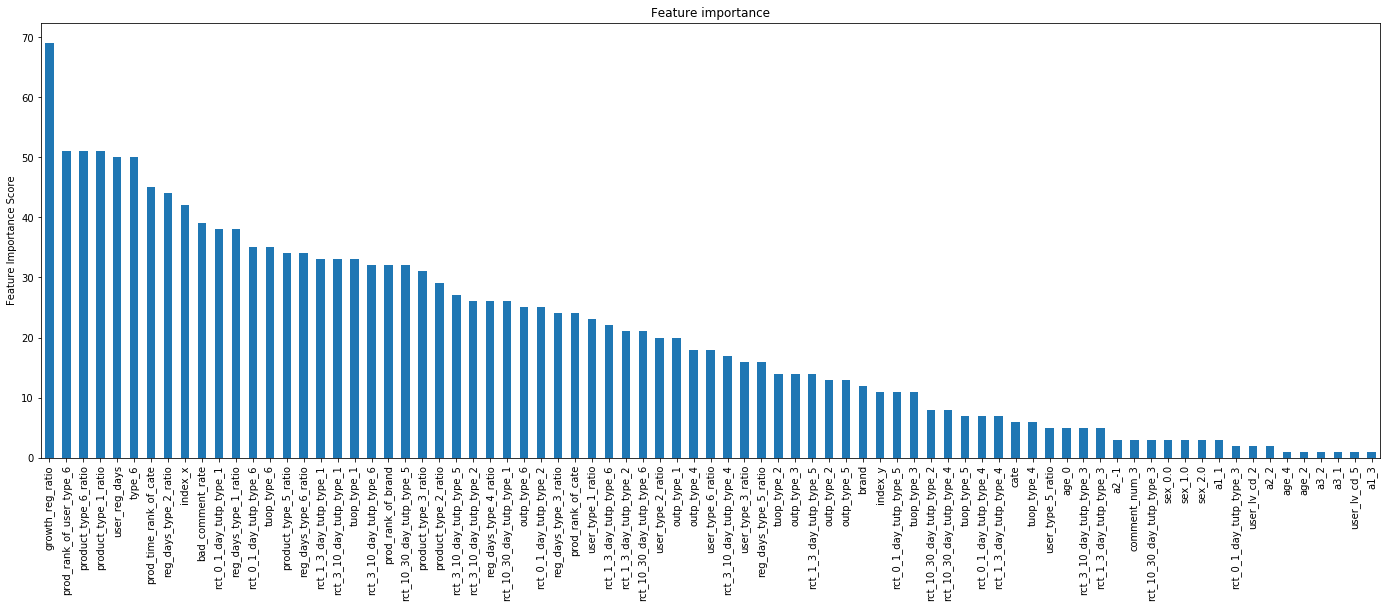

In [133]:
#def tun_parameters(train_x, train_y):
if True:
    xgb1 = XGBClassifier(learning_rate = 0.3,
                         n_estimators = 3000,
                         max_depth = 5,
                         min_child_weight = 1,
                         gamma = 0,
                         subsample = 0.8,
                         colsample_bytree = 0.8,
                         objective = 'binary:logistic',
                         nthread = 30,
                         scale_pos_weight = 1,
                         seed = 2017)
    result = modelMetrics(xgb1, train_x, train_y)

In [134]:
result

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.688979,0.038116,0.692111,0.029213
1,0.724713,0.051104,0.728194,0.039697
2,0.752466,0.030997,0.755810,0.018455
3,0.769884,0.017441,0.773712,0.009973
4,0.776102,0.019029,0.779566,0.007771
5,0.791563,0.020554,0.793238,0.008386
6,0.792139,0.019746,0.793817,0.008015
7,0.805321,0.026905,0.804262,0.017976
8,0.807641,0.025685,0.806404,0.016813
9,0.814318,0.032864,0.815795,0.024235


learning_rate = 0.3时,n_estimator为1752

In [136]:
param_test1 = {'max_depth': range(3, 10, 2),
               'min_child_weight': range(1, 6, 2)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.2,
                                                  n_estimators = 130,
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 30,
                                                  scale_pos_weight = 1,
                                                  seed = 17),
                        param_grid = param_test1,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch1.fit(train_x, train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/maqiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.88173, std: 0.01857, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.88012, std: 0.01774, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87566, std: 0.02255, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.86522, std: 0.03062, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86630, std: 0.02945, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86376, std: 0.02988, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.85094, std: 0.03720, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.85086, std: 0.03669, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.85531, std: 0.03615, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82803, std: 0.04823, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.84512, std: 0.03699, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.84339, std: 0.04458, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [33]:
param_test2 = {'max_depth': [8, 9, 10]}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.3,
                                                  n_estimators = 1800,
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 30,
                                                  scale_pos_weight = 1,
                                                  seed = 17),
                        param_grid = param_test1,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch2.fit(train_x, train_y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/home/maqiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.99788, std: 0.00007, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.99765, std: 0.00019, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.99748, std: 0.00014, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.99954, std: 0.00007, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.99945, std: 0.00008, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.99931, std: 0.00007, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.99972, std: 0.00008, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.99961, std: 0.00014, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.99953, std: 0.00015, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.99984, std: 0.00010, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.99977, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.99966, std: 0.00009, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_child_weight': 1

In [80]:
param_test3 = {'gamma': [i / 10.0 for i in range(4, 10)]}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.3,
                                                  n_estimators = 1300,
                                                  max_depth = 5,
                                                  min_child_weight = 5,
                                                  gamma = 0,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 30,
                                                  scale_pos_weight = 1,
                                                  seed = 17),
                        param_grid = param_test3,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch3.fit(train_x, train_y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/home/maqiao/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.91301, std: 0.03683, params: {'gamma': 0.4},
  mean: 0.91262, std: 0.03674, params: {'gamma': 0.5},
  mean: 0.91151, std: 0.03727, params: {'gamma': 0.6},
  mean: 0.91249, std: 0.03699, params: {'gamma': 0.7},
  mean: 0.91068, std: 0.03665, params: {'gamma': 0.8},
  mean: 0.91148, std: 0.03619, params: {'gamma': 0.9}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.89388123487050231)

In [82]:
param_test4 = {'subsample': [i / 10 for i in range(6, 10)],
              'colsample_bytree': [i / 10 for i in range(6, 10)]}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1,
                                                  n_estimators = 300,
                                                  max_depth = 3,
                                                  min_child_weight = 1,
                                                  gamma = 0.4,
                                                  subsample = 0.8,
                                                  colsample_bytree = 0.8,
                                                  objective = 'binary:logistic',
                                                  nthread = 30,
                                                  scale_pos_weight = 1,
                                                  seed = 17),
                        param_grid = param_test4,
                        scoring = 'roc_auc',
                        n_jobs = 30,
                        iid = False,
                        cv = 5)
gsearch4.fit(train_x, train_y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/maqiao/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/maqiao/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/pool.py", line 366, in _handle_workers
    pool._maintain_pool()
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/pool.py", line 240, in _maintain_pool
    self._repopulate_pool()
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/maqiao/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 20, 

TypeError: catching classes that do not inherit from BaseException is not allowed

In [44]:
#def xgboost_make_submission():
if True:
    train_start_date = '2016-03-10'
    train_end_date = '2016-04-11'
    test_start_date = '2016-04-11'
    test_end_date = '2016-04-16'

    sub_start_date = '2016-03-15'
    sub_end_date = '2016-04-16'
    
    user_index, training_data = make_train_set(train_end_date)
    label = get_test_labels(user_index, test_end_date)
    print(u'训练集和验证集中正样本数：%d, 负样本数：%d' % (label[label == 1].shape[0], label[label == 0].shape[0]))
    X_train, X_test, y_train, y_test = train_test_split(training_data.values,
                                                        label.values,
                                                        test_size=0.2,
                                                        random_state=0)
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)
    param = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 3,
             'min_child_weight': 5, 'gamma': 0, 'subsample': 1.0, 'colsample_bytree': 0.8,
             'scale_pos_weight': 1, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
    num_round = 400
    param['nthread'] = 30
    plst = list(param.items())
    plst += [('eval_metric', 'logloss')]
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    bst = xgb.train(plst, dtrain, num_round, evallist)
    sub_user_index, sub_training_data = make_train_set(sub_end_date)
    sub_user_index = sub_user_index[sub_training_data.cate == 8]
    sub_training_data = sub_training_data[sub_training_data.cate == 8]
    sub_training_data = xgb.DMatrix(sub_training_data.values)
    y = bst.predict(sub_training_data)
    sub_user_index['label'] = y
    pred = sub_user_index[sub_user_index['label'] >= 0.06]
    pred = pred[['user_id', 'sku_id']]
    pred = pred.groupby('user_id').max().reset_index()
    print(u'预测购买数：%d' % pred.shape[0])
    pred.to_csv('./sub/submission.csv', index=False, index_label=False)